In [2]:
pip install fastai numpy==1.26.4

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.3/235.3 kB 15.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 116.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 64.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 61.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.9/218.9 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 842.9/842.9 kB 49.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 74.7 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 77.7 MB/s eta 0:00:00:00:0

In [3]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
import shutil, random
from pathlib import Path
import matplotlib.pyplot as plt
import torch
from fastai.vision.all import (
    DataBlock, ImageBlock, CategoryBlock, get_image_files,
    GrandparentSplitter, parent_label, Resize, aug_transforms,
    vision_learner, accuracy, ClassificationInterpretation, resnet34)
from fastai.torch_core import default_device
from fastai.callback.tracker import EarlyStoppingCallback, SaveModelCallback
import time

In [4]:
# device selection
def set_device():
    if torch.cuda.is_available(): default_device('cuda'); print('使用CUDA加速')
    elif torch.backends.mps.is_available(): default_device('mps'); print('使用MPS加速')
    else: default_device('cpu'); print('使用CPU')
set_device()

使用CUDA加速


In [5]:
def split_dataset(src_base_path, dest_base_path, categories, train_ratio, valid_ratio, test_ratio):
    assert train_ratio + valid_ratio + test_ratio == 1, "Ratios should add up to 1."
    
    # Remove existing destination directory if it exists
    if dest_base_path.exists():
        shutil.rmtree(dest_base_path)
    
    # Create destination directories
    for phase in ['train', 'valid', 'test']:
        for cat in categories:
            os.makedirs(dest_base_path/phase/cat, exist_ok=True)
    
    # Split and copy files for each category
    for cat in categories:
        files = list((Path(src_base_path)/cat).glob('*.*'))
        random.shuffle(files)
        n = len(files)
        
        # Calculate split indices
        train_end = int(n * train_ratio)
        valid_end = train_end + int(n * valid_ratio)
        
        # Split files into three sets
        train_files = files[:train_end]
        valid_files = files[train_end:valid_end]
        test_files = files[valid_end:]
        
        # Copy files to respective directories
        for f in train_files:
            shutil.copy(f, dest_base_path/'train'/cat/f.name)
        for f in valid_files:
            shutil.copy(f, dest_base_path/'valid'/cat/f.name)
        for f in test_files:
            shutil.copy(f, dest_base_path/'test'/cat/f.name)
        
        # Print statistics for each category
        print(f"\nCategory: {cat}")
        print(f"Total files: {n}")
        print(f"Train set: {len(train_files)} files")
        print(f"Valid set: {len(valid_files)} files")
        print(f"Test set: {len(test_files)} files")
        
        # Verify the splits
        assert len(train_files) + len(valid_files) + len(test_files) == n, \
            f"Split verification failed for category {cat}"
    
    # Print overall statistics
    print("\nOverall Dataset Statistics:")
    for phase in ['train', 'valid', 'test']:
        total_files = sum(len(list((dest_base_path/phase/cat).glob('*.*'))) 
                        for cat in categories)
        print(f"{phase.capitalize()} set: {total_files} files")

In [6]:
src_base_path = Path('dishes')
dest_base_path = Path('images')
cats= ['炒合菜','葱爆羊肉','地三鲜']
split_dataset(src_base_path, dest_base_path, cats, 0.6, 0.2, 0.2)


Category: 炒合菜
Total files: 30
Train set: 18 files
Valid set: 6 files
Test set: 6 files

Category: 葱爆羊肉
Total files: 30
Train set: 18 files
Valid set: 6 files
Test set: 6 files

Category: 地三鲜
Total files: 30
Train set: 18 files
Valid set: 6 files
Test set: 6 files

Overall Dataset Statistics:
Train set: 54 files
Valid set: 18 files
Test set: 18 files


In [7]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='train', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)
)
dls = dblock.dataloaders(dest_base_path, bs=48)

In [18]:
# 在创建dls后添加
print(f"训练集文件数量: {len(dls.train_ds)}")
print(f"验证集文件数量: {len(dls.valid_ds)}")

训练集文件数量: 54
验证集文件数量: 18


In [19]:
from PIL import Image
import os

def verify_images(path):
    for root, dirs, files in os.walk(path):
        for file in files:
            try:
                img_path = os.path.join(root, file)
                with Image.open(img_path) as img:
                    img.verify()
            except Exception as e:
                print(f"损坏文件: {img_path} - {e}")
                
verify_images("images/train")
verify_images("images/valid")

In [20]:
print(f"训练集批次数量: {len(dls.train)}")
print(f"验证集批次数量: {len(dls.valid)}")

训练集批次数量: 1
验证集批次数量: 1


/environment/miniconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 33905 (\N{CJK UNIFIED IDEOGRAPH-8471}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/environment/miniconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 29190 (\N{CJK UNIFIED IDEOGRAPH-7206}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/environment/miniconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 32650 (\N{CJK UNIFIED IDEOGRAPH-7F8A}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/environment/miniconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 32905 (\N{CJK UNIFIED IDEOGRAPH-8089}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/environment/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 33905 (\N{CJK UNIFIED IDEOGRAPH-8471}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **k

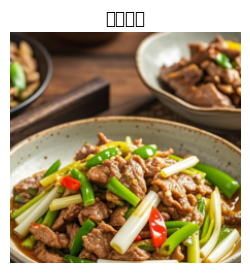

In [21]:
dls.show_batch(max_n=1)  # 显示最多9张图片

In [22]:
early_stop_cb = EarlyStoppingCallback(monitor='valid_loss', patience=5, min_delta=0.01)
save_model_cb = SaveModelCallback(monitor='valid_loss', fname='best_model')

In [23]:
learn = vision_learner(dls, resnet34, metrics=accuracy, cbs=[early_stop_cb, save_model_cb])

In [24]:
# ... existing code ...

# 检查并修复图像文件
from PIL import Image
import os

def check_and_fix_images(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # 验证图像文件是否完整
            except Exception as e:
                print(f"文件 {file_path} 损坏或不支持，已删除: {e}")
                os.remove(file_path)  # 删除损坏或不支持的文件

# 检查并修复训练集和验证集中的图像文件
check_and_fix_images('images/train')
check_and_fix_images('images/valid')

# ... existing code ...
learn.fine_tune(100)

epoch,train_loss,valid_loss,accuracy,time
0,1.614532,3.687262,0.333333,00:01


Better model found at epoch 0 with valid_loss value: 3.6872618198394775.


epoch,train_loss,valid_loss,accuracy,time
0,1.461792,2.752842,0.388889,00:02
1,1.360863,2.130695,0.388889,00:02
2,1.326677,1.671951,0.388889,00:01
3,1.096784,1.427194,0.500000,00:02
4,0.938100,1.186104,0.555556,00:01
5,0.852671,0.975817,0.611111,00:01
6,0.758971,0.790930,0.611111,00:01
7,0.708872,0.639091,0.666667,00:01
8,0.636880,0.517403,0.722222,00:01
9,0.575549,0.401991,0.777778,00:01


Better model found at epoch 0 with valid_loss value: 2.7528417110443115.
Better model found at epoch 1 with valid_loss value: 2.13069486618042.
Better model found at epoch 2 with valid_loss value: 1.6719509363174438.
Better model found at epoch 3 with valid_loss value: 1.4271936416625977.
Better model found at epoch 4 with valid_loss value: 1.1861035823822021.
Better model found at epoch 5 with valid_loss value: 0.9758166074752808.
Better model found at epoch 6 with valid_loss value: 0.7909303903579712.
Better model found at epoch 7 with valid_loss value: 0.6390905380249023.
Better model found at epoch 8 with valid_loss value: 0.5174026489257812.
Better model found at epoch 9 with valid_loss value: 0.40199077129364014.
Better model found at epoch 10 with valid_loss value: 0.31801697611808777.
Better model found at epoch 11 with valid_loss value: 0.2538253664970398.
Better model found at epoch 12 with valid_loss value: 0.20361866056919098.
Better model found at epoch 13 with valid_loss 

In [25]:
test_dl = dls.test_dl(get_image_files(dest_base_path/'test'), with_labels=True)
loss, acc = learn.validate(dl=test_dl)

Better model found at epoch 0 with valid_loss value: 1.0.


In [26]:
test_dl = dls.test_dl(get_image_files(dest_base_path/'test'), with_labels=True)
loss, acc = learn.validate(dl=test_dl)

Better model found at epoch 0 with valid_loss value: 1.0.


In [27]:
test_dl = dls.test_dl(get_image_files(dest_base_path/'test'), with_labels=True)
loss, acc = learn.validate(dl=test_dl)

Better model found at epoch 0 with valid_loss value: 1.0.


In [28]:
loss

0.05727122351527214

In [29]:
acc

1.0

/environment/miniconda3/lib/python3.11/site-packages/fastai/interpret.py:151: UserWarning: Glyph 22320 (\N{CJK UNIFIED IDEOGRAPH-5730}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/environment/miniconda3/lib/python3.11/site-packages/fastai/interpret.py:151: UserWarning: Glyph 19977 (\N{CJK UNIFIED IDEOGRAPH-4E09}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/environment/miniconda3/lib/python3.11/site-packages/fastai/interpret.py:151: UserWarning: Glyph 40092 (\N{CJK UNIFIED IDEOGRAPH-9C9C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/environment/miniconda3/lib/python3.11/site-packages/fastai/interpret.py:151: UserWarning: Glyph 28818 (\N{CJK UNIFIED IDEOGRAPH-7092}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/environment/miniconda3/lib/python3.11/site-packages/fastai/interpret.py:151: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/environment/miniconda3/lib/python3.11/site-p

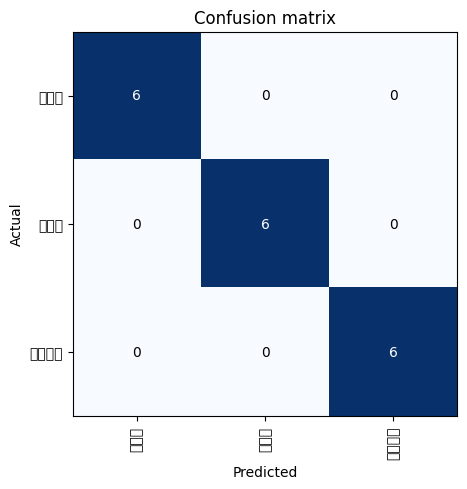

In [30]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [32]:
interp.print_classification_report()

              precision    recall  f1-score   support

         地三鲜       1.00      1.00      1.00         6
         炒合菜       1.00      1.00      1.00         6
        葱爆羊肉       1.00      1.00      1.00         6

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18



/environment/miniconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 33905 (\N{CJK UNIFIED IDEOGRAPH-8471}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/environment/miniconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 29190 (\N{CJK UNIFIED IDEOGRAPH-7206}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/environment/miniconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 32650 (\N{CJK UNIFIED IDEOGRAPH-7F8A}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/environment/miniconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 32905 (\N{CJK UNIFIED IDEOGRAPH-8089}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/environment/miniconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 28818 (\N{CJK UNIFIED IDEOGRAPH-7092}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/environment/minicon

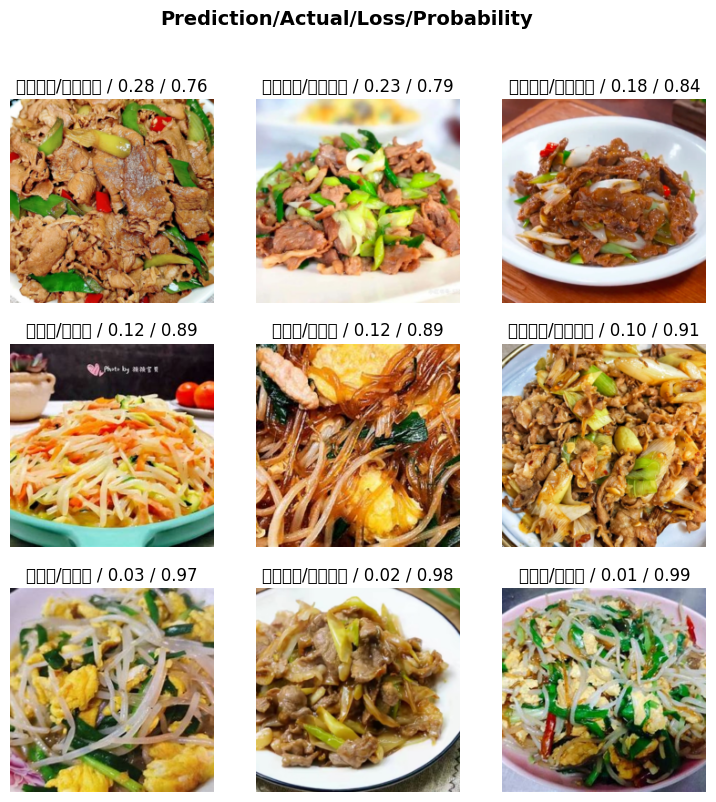

In [33]:
interp.plot_top_losses(9)

In [35]:
learn.export('dish.pkl')